### Tasks:
- Create a Jupyter notebook called random_forest_titantic.ipynb.
- Load, clean, and preprocess the data from the titanic.csv file. You may reuse any code you may have used previously to clean and preprocess this
dataset.
- Create a random forest to predict the survival of passengers on the Titanic.
- From the random forest model, determine which of the features is the one
that contributes the most to predicting whether a passenger survives or
not.
- Tune the n_estimators (the number of trees in the model) and max_depth (the maximum depth of each tree) parameters.
- Report the accuracy of all models and report which model performed the best, including the values for n_estimators and max_depth that the best model had.


In [29]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import matplotlib.pyplot as plt
%matplotlib inline

- Load, clean, and preprocess the data from the titanic.csv file. You may reuse any code you may have used previously to clean and preprocess this
dataset.

In [30]:
# Load the titanic dataset
titanic_df = pd.read_csv("titanic.csv")
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [31]:
# Print Information about the DataFrame
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


EDA and Preprocessing of data

In [32]:
# Check for missing values (if there is any)

titanic_df.isnull().sum() # We found no missing value, so we proceed.

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [33]:
# Check for duplications if there is any
titanic_df.duplicated().sum()

np.int64(0)

In [34]:
# Drop the 'Cabin' column, as it's not needed for our analysis.
titanic_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)


# Handling of missing values:

# Impute 'Age' with the median
titanic_df['Age'] = titanic_df['Age'].fillna(titanic_df['Age'].median())

# Impute 'Embarked' missing values with mode
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0])

In [35]:
# Return unique values from the Sex column
titanic_df["Sex"].unique()

array(['male', 'female'], dtype=object)

In [36]:
# Apply one-hot encoding to the 'Sex' column
titanic_df = pd.get_dummies(titanic_df, prefix="Sex", columns=["Sex"]) # This converts our new column data into boolean
titanic_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male
0,0,3,22.0,1,0,7.2500,S,False,True
1,1,1,38.0,1,0,71.2833,C,True,False
2,1,3,26.0,0,0,7.9250,S,True,False
3,1,1,35.0,1,0,53.1000,S,True,False
4,0,3,35.0,0,0,8.0500,S,False,True


In [37]:
# Convert 'Embarked' to boolean

# Apply one-hot encoding to the 'Embarked' column
titanic_df = pd.get_dummies(titanic_df, prefix="Embarked", columns=["Embarked"])
titanic_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,1,38.0,1,0,71.2833,True,False,True,False,False
2,1,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,1,35.0,1,0,53.1000,True,False,False,False,True
4,0,3,35.0,0,0,8.0500,False,True,False,False,True


In [38]:
# Using Pandas astype, we convert the boolean values to numbers with True = 1 and False = 0
titanic_df['Sex_female'] = titanic_df['Sex_female'].astype(int)
titanic_df['Sex_male'] = titanic_df['Sex_male'].astype(int)

# Convert 'Embarked boolean' to numerical (0 for False and 1 for True)
titanic_df['Embarked_C'] = titanic_df['Embarked_C'].astype(int)
titanic_df['Embarked_Q'] = titanic_df['Embarked_Q'].astype(int)
titanic_df['Embarked_S'] = titanic_df['Embarked_S'].astype(int)

titanic_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [39]:
# Define the Indendent and dependent variables

# X =   Independent variables
# y =   Dependent variable
X = titanic_df.drop('Survived', axis=1)
y = titanic_df['Survived']

print('Independent Variables (X):')
print(X.head())
print('\nDependent Variables (y):')
print(y.head())

Independent Variables (X):
   Pclass   Age  SibSp  Parch     Fare  Sex_female  Sex_male  Embarked_C  \
0       3  22.0      1      0   7.2500           0         1           0   
1       1  38.0      1      0  71.2833           1         0           1   
2       3  26.0      0      0   7.9250           1         0           0   
3       1  35.0      1      0  53.1000           1         0           0   
4       3  35.0      0      0   8.0500           0         1           0   

   Embarked_Q  Embarked_S  
0           0           1  
1           0           0  
2           0           1  
3           0           1  
4           0           1  

Dependent Variables (y):
0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64


In [40]:
# Split the data into training (70%),  and testing (30%) data subsets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split training data into training and development set (75% and 25%  of the original training set)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("X_train shape:", X_train.shape)
print("X_dev shape:", X_dev.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_dev shape:", y_dev.shape)
print("y_test shape:", y_test.shape)

X_train shape: (467, 10)
X_dev shape: (156, 10)
X_test shape: (268, 10)
y_train shape: (467,)
y_dev shape: (156,)
y_test shape: (268,)


Create a random forest to predict the survival of passengers on the Titanic.

In [41]:
# We create Random Forest Classifier
rand_forest = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rand_forest.fit(X_train, y_train)

# Evaluate Model
y_pred = rand_forest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Test Accuracy: {accuracy:.2f}")

Random Forest Test Accuracy: 0.79


From the random forest model, determine which of the features is the one
that contributes the most to predicting whether a passenger survives or
not.

Feature Importances:
Age           0.258172
Fare          0.249768
Sex_male      0.155453
Sex_female    0.118434
Pclass        0.077966
SibSp         0.053770
Parch         0.044138
Embarked_S    0.016666
Embarked_C    0.016286
Embarked_Q    0.009348
dtype: float64


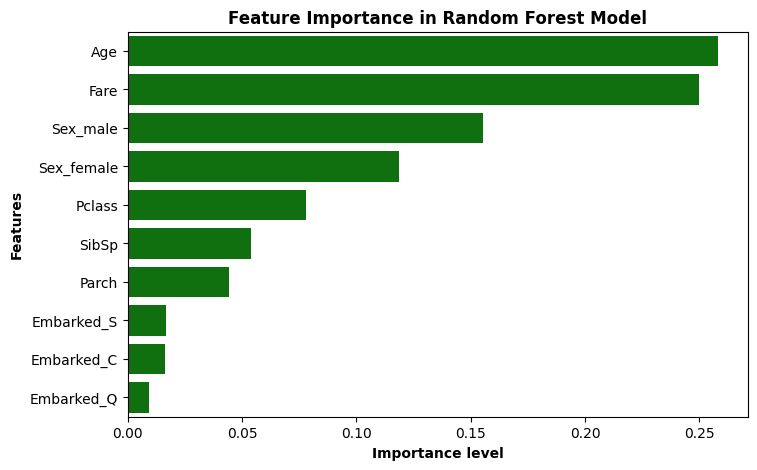


The most important feature for the Titanic survival is: Age


In [42]:
#Feature Importance Analysis

feat_importance = pd.Series(rand_forest.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importances:")
print(feat_importance)

# To Visualise feature importances
plt.figure(figsize=(8, 5))
sns.barplot(x=feat_importance, y=feat_importance.index, color='green')
plt.title("Feature Importance in Random Forest Model", weight='bold')
plt.xlabel('Importance level', weight='bold')
plt.ylabel('Features', weight='bold')
plt.show()

# Create a DataFrame to display feature importances
feat_importance = pd.DataFrame({'Feature': X.columns, 'Importance': feat_importance})
feat_importance = feat_importance.sort_values('Importance', ascending=False).reset_index(drop=True)

# Identify the most important feature
most_important_feature = feat_importance['Feature'][1]
print(f"\nThe most important feature for the Titanic survival is: {most_important_feature}")

- Tune the n_estimators (the number of trees in the model) and max_depth (the maximum depth of each tree) parameters.
- Report the accuracy of all models and report which model performed the best, including the values for n_estimators and max_depth that the best model had.

In [43]:
# Parameter Tuning (n_estimators and max_depth)

n_estimators_list = [50, 100, 150, 200]
max_depth_list = [5, 10, 15]

best_accuracy = 0
best_parameters = {}

for n in n_estimators_list:
    for depth in max_depth_list:
        rand_forest = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=42)
        
        rand_forest.fit(X_train, y_train)
        
        y_pred = rand_forest.predict(X_test)
        
        accur = accuracy_score(y_test, y_pred)
        print(f"n_estimators={n}, max_depth={depth}, Accuracy={accur:.2f}")
        
        if accur > best_accuracy:
            best_accuracy = accur
            best_parameters = {"n_estimators": n, "max_depth": depth}

print(f"\nBest Model: n_estimators = {best_parameters['n_estimators']}, \nmax_depth  = {best_parameters['max_depth']}, \nTest Set Accuracy = {best_accuracy:.2f}")


n_estimators=50, max_depth=5, Accuracy=0.80
n_estimators=50, max_depth=10, Accuracy=0.80
n_estimators=50, max_depth=15, Accuracy=0.79
n_estimators=100, max_depth=5, Accuracy=0.81
n_estimators=100, max_depth=10, Accuracy=0.81
n_estimators=100, max_depth=15, Accuracy=0.79
n_estimators=150, max_depth=5, Accuracy=0.80
n_estimators=150, max_depth=10, Accuracy=0.80
n_estimators=150, max_depth=15, Accuracy=0.79
n_estimators=200, max_depth=5, Accuracy=0.80
n_estimators=200, max_depth=10, Accuracy=0.80
n_estimators=200, max_depth=15, Accuracy=0.78

Best Model: n_estimators = 100, 
max_depth  = 5, 
Test Set Accuracy = 0.81


### Summary
- Development Set Accuracy: 0.79
- Most Important Feature: Age 
- Best Model: n_estimators = 100, max_depth = 5, Accuracy = 0.81 
- Test Set Accuracy: 0.81 

In [44]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

### Challenge